# Time to get your hands dirty! Supernova distances and redshifts (part 2 - 3)

## Part 2 (start in class)

First let’s fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what’s available in the `kernels` submodule of `sklearn.gaussian_process`
- Plot the expectation value of the fit as well as the resulting 1-σ and 2-σ contours.
- Interpret the results.

> *Note.* To start with, feel free to tweak the hyperparameters manually. But, of course, a publication-quality result will require a cross-validation analysis.

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We’ve seen this earlier in the class, but now we can do much much better.

- Think about the pdf of these data in *z*.
- Using your GPR fit, generate a set of *μ* measurements that respects the statistical properties of the data you were given.

---

## Part 3 (for the exam)

> *(I know this assignment is longer and more convoluted, but we’re getting towards the end of the class and it’s important to draw connections between the different things we’ve done)*

We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow’s stock market… You might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we do have physical theory which is ΛCDM. We can do a **parametric** fit (and hopefully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module *μ* and the redshift *z*. *Hint:* I always forget these things, my to-go reference is Hogg (2010). The answer is:

  $$
  \mu = 5 \log \left( \frac{c/H_0}{10 \text{pc}} (1+z) \int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + \Omega_\Lambda}} \right)
  $$

- Assuming a flat Universe, we have a parametric non-linear model for *μ(z)* that depends on two parameters, the Hubble constant *H₀* and the matter content of the Universe *Ωₘ*.
- It’s a very non-linear model. Fit it to the data, however you want to do it, using techniques we’ve seen throughout the course. Some suggestions:
  - Set up a Bayesian framework and use MCMC.
  - Set up a fully-connected neural network (see end of the class).
- What are the measured value of *H₀* and *Ωₘ*. What's they errors? Are they correlated?
- How would a model without dark energy (i.e. *Ωₘ*=1) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

In [15]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel 
from sklearn.neighbors import KernelDensity
from astropy.cosmology import LambdaCDM
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import emcee
import scipy.stats
import corner
import dynesty

(35.0, 50.0)

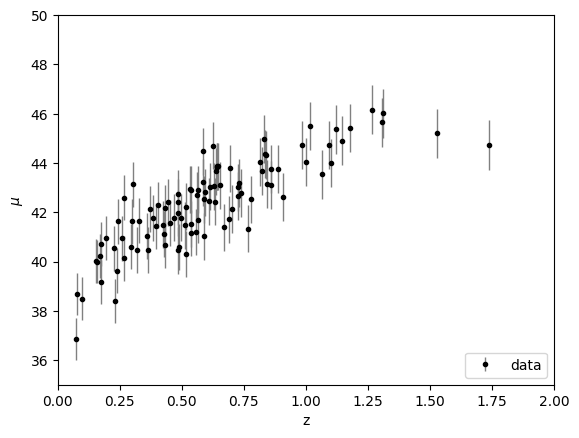

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) ###YOU CAN'T CHANGE THIS

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

In [4]:
# Kernel = Constant * RBF + WhiteKernel
# ConstantKernel: sets amplitude of μ(z)
# RBF (Radial Basis Function) controls the smoothness of the function: it defines how much μ(z) can change when z varies
#  → the 'length_scale' parameter controls how quickly or slowly the function varies with z
# - WhiteKernel: models measurement noise (dmu)

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))


gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=dmu**2,  # includes observational uncertainties
                              normalize_y=True)  # True centers the target variable
gp.fit(z_sample.reshape(-1, 1), mu_sample)  

/home/sara/myenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=array([0.84387183, 0.91812087, 0.89001003, 0.94522717, 0.94422381,
       0.86154897, 0.86230499, 0.94838417, 0.9933467 , 0.9646779 ,
       0.87701523, 0.89976228, 0.92772472, 0.93248803, 0.87910942,
       0.90886653, 0.90007965, 0.74796941, 0.94290888, 0.96641079,
       0.87820976, 0.91709206, 0.80479835, 0.87887073, 0.98216481,
       0.92265029, 0.8835475 , 0.94586178, 0.86985...
       0.97119502, 0.88669278, 0.90504074, 0.72518962, 0.86689404,
       0.88987903, 0.91659546, 0.97685316, 0.91867826, 0.93138181,
       0.83270862, 0.93814442, 0.95430226, 0.9199094 , 0.89010136,
       0.83350663, 0.90995601, 0.90388843, 0.98995206, 0.89661359,
       0.90000008, 0.90519576, 0.95184399, 0.79454928, 0.92548723]),
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         normalize_y=True)

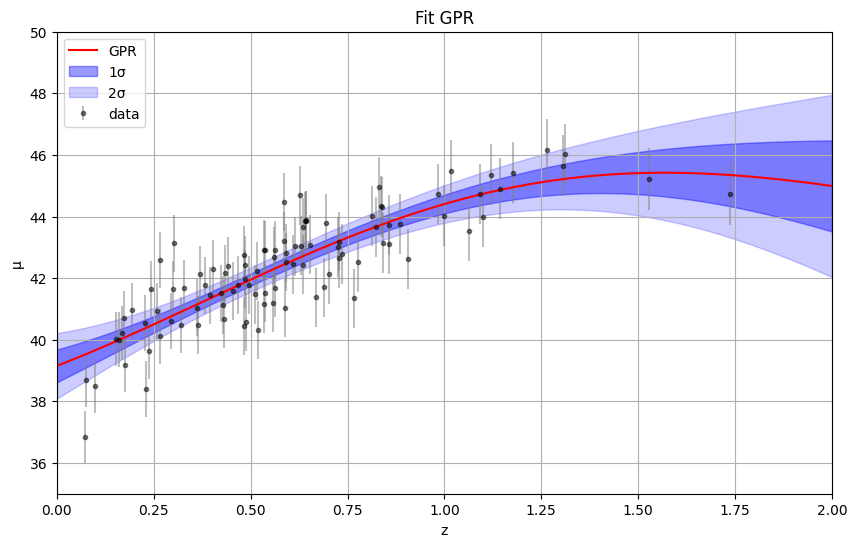

Optimize Kernel: 2.21**2 * RBF(length_scale=1.11) + WhiteKernel(noise_level=1e-05)


In [5]:
# Predict μ(z) and its uncertainty using the trained Gaussian Process
z_fit = np.linspace(0, 2, 1000).reshape(-1, 1)  
mu_pred, sigma = gp.predict(z_fit, return_std=True) 
plt.figure(figsize=(10, 6))
# Plot data with error bars and GPR prediction with confidence bands
plt.errorbar(z_sample, mu_sample, dmu, fmt=".k", ecolor='gray', label='data', alpha=0.5)
plt.plot(z_fit, mu_pred, 'r', label="GPR")
plt.fill_between(z_fit.ravel(), mu_pred - sigma, mu_pred + sigma, color='blue', alpha=0.4, label="1σ")
plt.fill_between(z_fit.ravel(), mu_pred - 2*sigma, mu_pred + 2*sigma, color='blue', alpha=0.2, label="2σ")
plt.xlabel("z")
plt.ylabel("μ")
plt.title("Fit GPR")
plt.legend()
plt.grid()
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()
print("Optimize Kernel:", gp.kernel_) # Print the optimized kernel after training

Generate mock data (cloning)

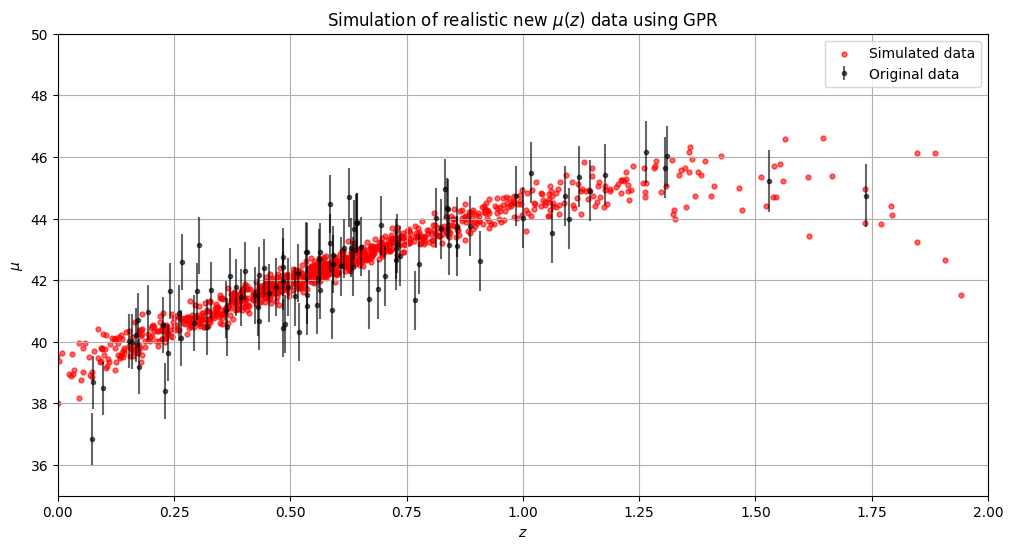

In [6]:
z_val = np.array(z_sample).reshape(-1, 1)
# KDE: estimate the pdf of z_sample
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(z_val)
# Sample new z values from the estimated density 
z_new = kde.sample(1000).reshape(-1)
z_new_sorted = np.sort(z_new)  # sort for clearer plotting

#Predict mean and std dev of mu for the new z values using the GPR model
mu_new_pred, sigma_new_pred = gp.predict(z_new_sorted.reshape(-1, 1), return_std=True)

# Simulate new μ values by sampling from normal distributions with predicted mean and std dev
mu_simulated = np.random.normal(mu_new_pred, sigma_new_pred)

#Plot original data with error bars and simulated data points
plt.figure(figsize=(12, 6))
plt.errorbar(z_sample, mu_sample,dmu, fmt='.k', alpha=0.6, label='Original data')
plt.scatter(z_new_sorted, mu_simulated, color='red', s=50, alpha=0.6, label='Simulated data', marker='.')

plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend()
plt.title("Simulation of realistic new $\mu(z)$ data using GPR")
plt.grid(True)
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()



Part 3. Non linear fitting

MCMC

In [ ]:
def model(redshift, Hubble_const, omega_matter=1):
    cosmology = LambdaCDM(H0=Hubble_const, Om0=omega_matter, Ode0=1 - omega_matter) # The cosmological model
    dist_modulus = cosmology.distmod(redshift) # Calculate the distance modulus at the specified redshift
    return dist_modulus.value

#Compute loglikelihood
def loglikelihood(parameters):
    omega_m, hubble = parameters
    if omega_m < 0:
        return -np.inf
    
    # Compute the predicted distance modulus using the model
    mu_model = model(z_sample, hubble, omega_m)
    return -0.5 * np.sum(((mu_sample - mu_model) / dmu)**2 + np.log(2 * np.pi * dmu**2))

def logprior(parameters):
    omega_m, hubble = parameters
    # Uniform prior: return 0 if parameters are within bounds, else -inf
    # Hubble range chosen to cover current observational estimates (~50 to 100 km/s/Mpc)
    # Omega_m range reflects physically plausible matter density values (0.1 to 1)
    if 50 < hubble < 100 and 0.1 < omega_m < 1:
        return 0.0
    return -np.inf

def log_posterior(parameters):
    # Sum of log-likelihood and log-prior to get log-posterior
    return loglikelihood(parameters) + logprior(parameters)



In [17]:
ndim = 2  # number of parameters in the model
nwalkers = 5  # number of MCMC walkers
nsteps = 10000 # number of MCMC steps to take for each walker
# Initialize walker positions around [0.5, 80] by adding small Gaussian noise
# This creates slightly different starting points for each walker to explore parameter space efficiently
pos = np.array([0.5,80]) + 1e-1* np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(pos, nsteps) # Run the MCMC chains

print("done")

done


Text(0.5, 0, 'step number')

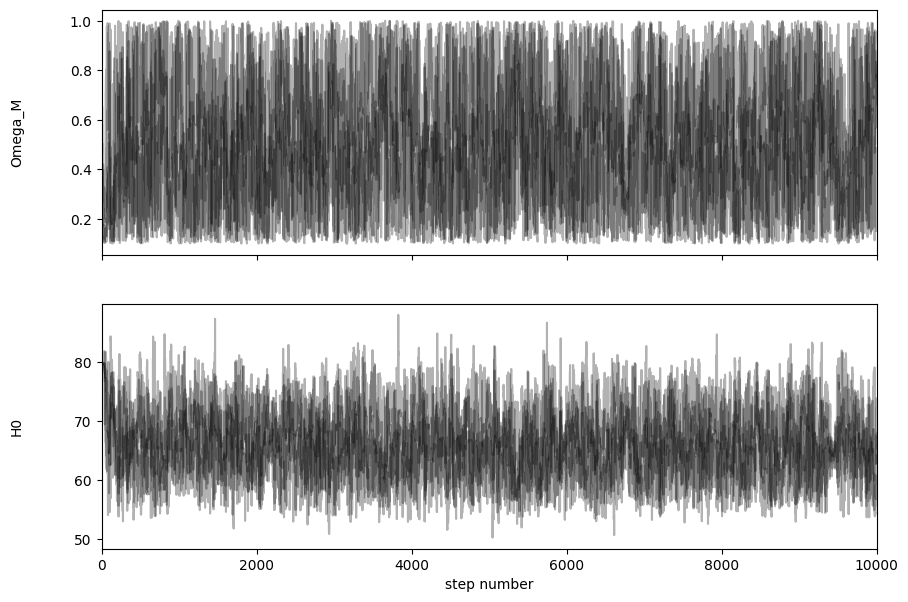

In [20]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain() # Extract the MCMC chains from the sampler
labels = ["Omega_M", "H0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3) # Plot the trace of all walker
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [21]:
autocor_time=sampler.get_autocorr_time() # Calculate the autocorrelation time for each parameter
print(autocor_time)
# Flatten the MCMC chains by discarding initial samples (burn-in) and thinning according to autocorrelation time
flat_samples = sampler.get_chain(discard=3*int(max(autocor_time)), thin=int(max(autocor_time)), flat=True)
print(flat_samples.shape)

[49.3653524  49.37693158]
(1005, 2)


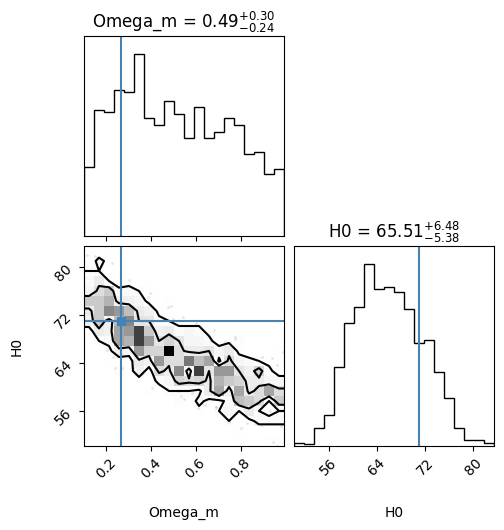

In [22]:
fig = corner.corner( flat_samples, labels=["Omega_m","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71])

(35.0, 50.0)

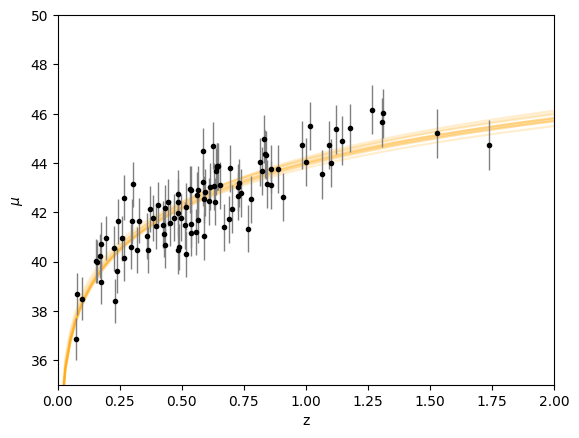

In [34]:
#Select 100 samples from the posterior distribution
# For each sample, compute the model prediction and plot it
z = np.linspace(0.01,2,100)
for omega_matter, hubble_const in flat_samples[::100]:
    predicted_mu = model(z, hubble_const, omega_matter)
    plt.plot(z, predicted_mu, color='orange', alpha=0.2)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
    

Nested sampling

In [8]:
def prior_transform(u):
    # u: array with 2 values sampled uniformly from [0,1]
    # Transform first parameter from [0,1] to Omega_m in [0.1, 1]
    omega_m = 0.1 + 0.9 * u[0]
    
    # Transform second parameter from [0,1] to H0 in [30, 100]
    H0 = 30 + 70 * u[1]
    return np.array([omega_m, H0])

In [9]:
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim=2, nlive=1000)
# Run nested sampling
sampler.run_nested()
sresults = sampler.results

2799it [00:21, 132.50it/s, +1000 | bound: 0 | nc: 1 | ncall: 17633 | eff(%): 22.840 | loglstar:   -inf < -132.814 <    inf | logz: -135.327 +/-  0.021 | dlogz:  0.001 >  1.009]


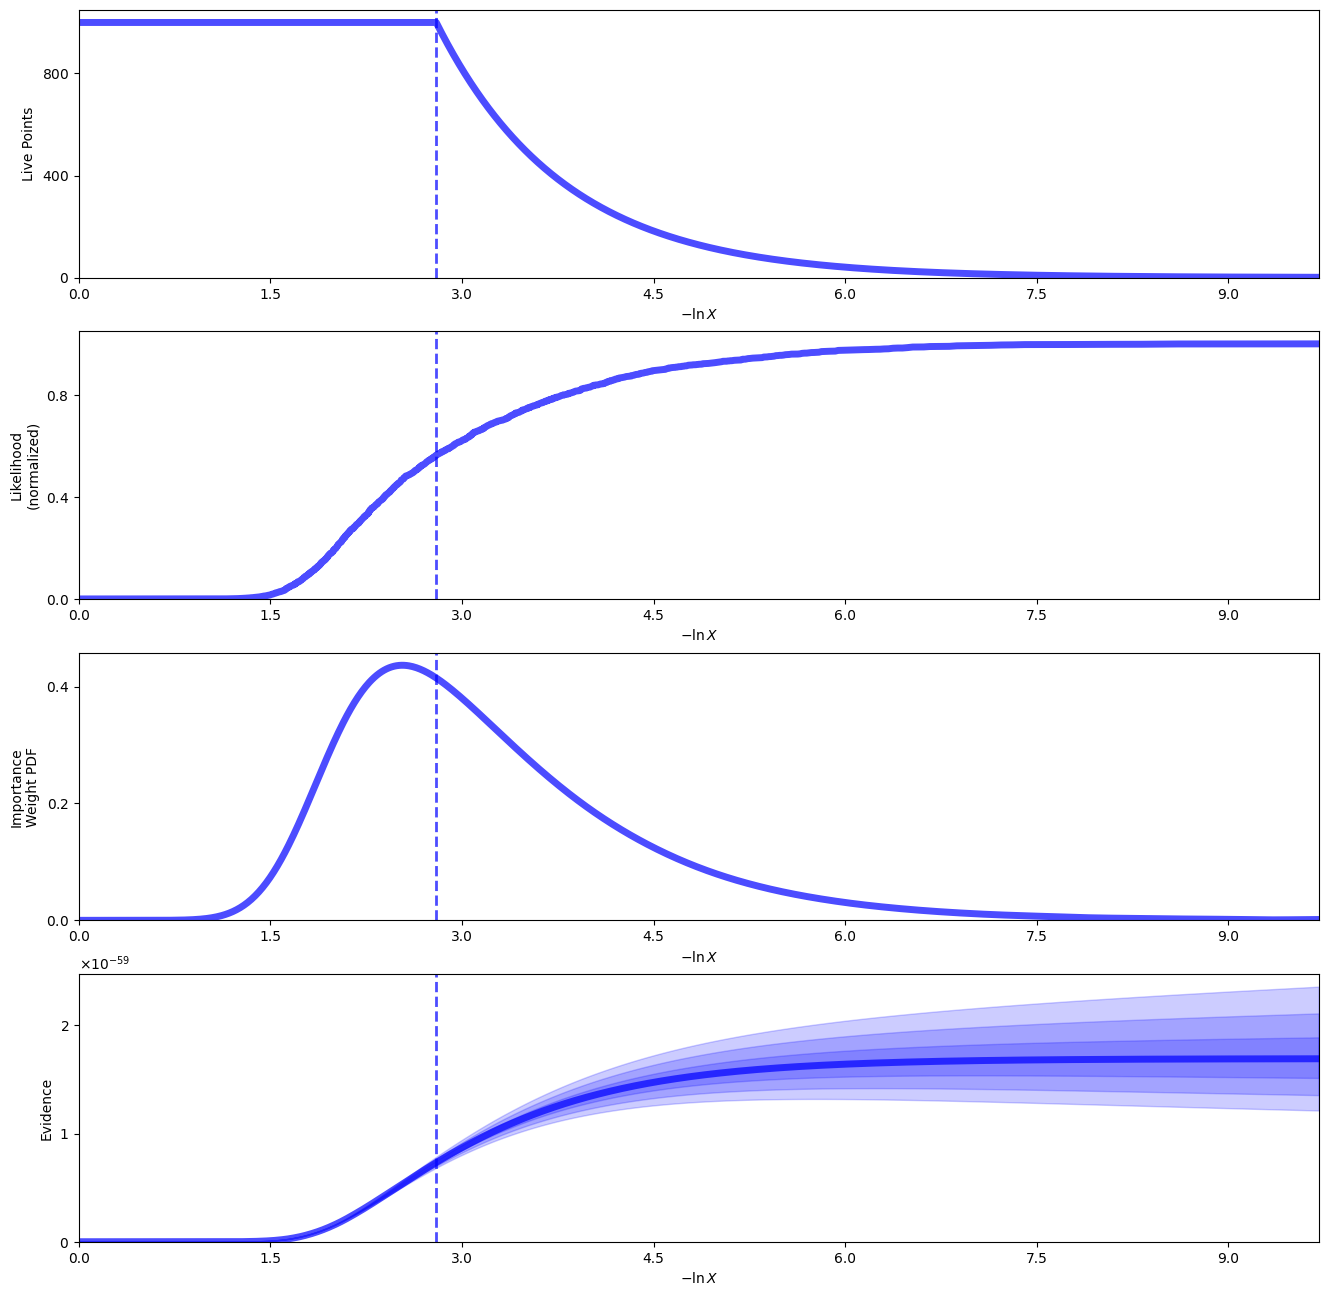

In [ ]:
rfig, raxes = dyplot.runplot(sresults) # Shows how the nested sampling evolves

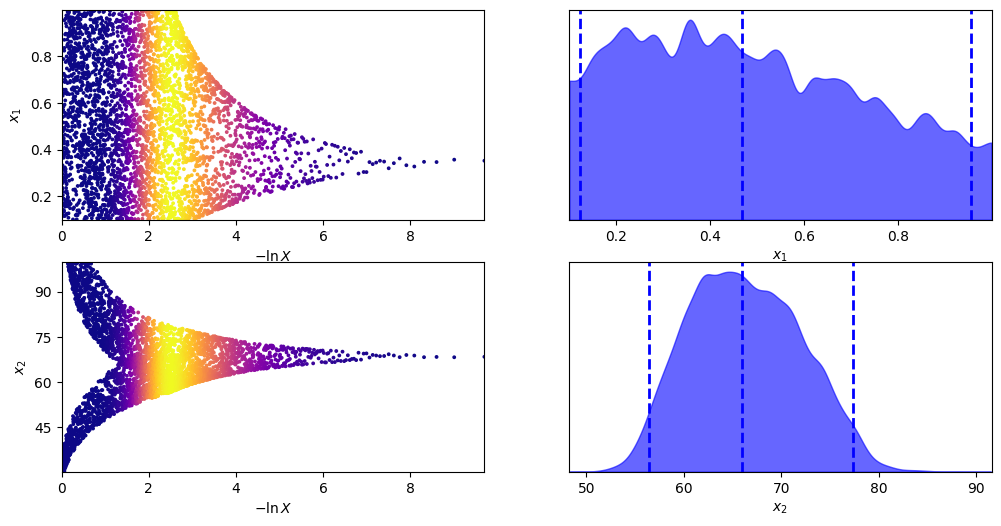

In [ ]:
tfig, taxes = dyplot.traceplot(sresults) # Shows trace plots of parameter samples over iterations

In [ ]:
# Compute weighted mean and standard deviation of parameters from nested sampling results
samples = sresults.samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples, weights)
std_dev = np.sqrt(np.diag(cov))

print(f"Omega_m = {mean[0]:.3f} ± {std_dev[0]:.3f}")
print(f"H0 = {mean[1]:.2f} ± {std_dev[1]:.2f}")

Omega_m = 0.492 ± 0.241
H0 = 66.30 ± 5.67


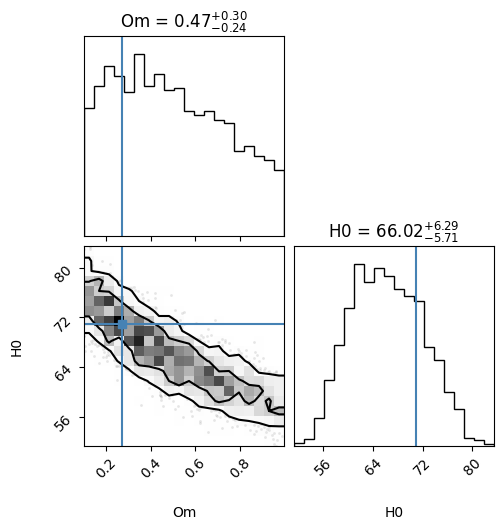

In [ ]:
samples_equal = dyfunc.resample_equal(samples, weights) #dynesty returns weighted samples — this converts them to equally-weighted ones
fig = corner.corner(samples_equal, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71])

In [19]:
def model_no_dark_energy(redshift, Hubble_const):
    cosmology = LambdaCDM(H0=Hubble_const, Om0=1, Ode0=0)
    dist_modulus = cosmology.distmod(redshift)
    return dist_modulus.value

def loglikelihood_no_dark_energy(params):
    H0, = params
    mu_model = model_no_dark_energy(z_sample, H0)
    return -0.5 * np.sum(((mu_sample - mu_model) / dmu)**2 + np.log(2 * np.pi * dmu**2))

def prior_transform_no_dark_energy(u):
    # Uniform prior on H0 between 30 and 100 km/s/Mpc
    H0 = 30 + 70 * u[0]
    return np.array([H0])


In [ ]:
# Run nested sampling
sampler_noDE = dynesty.NestedSampler(loglikelihood_no_dark_energy, prior_transform_no_dark_energy, ndim=1, nlive=1000)
sampler_noDE.run_nested()
results_noDE = sampler_noDE.results

2737it [00:17, 159.08it/s, +1000 | bound: 0 | nc: 1 | ncall: 17075 | eff(%): 23.247 | loglstar:   -inf < -133.530 <    inf | logz: -135.891 +/-    nan | dlogz:  0.001 >  1.009]


In [ ]:
# Compute mean and standard deviation for H0
samples_noDE = results_noDE.samples # samples
weights_noDE = np.exp(results_noDE.logwt - results_noDE.logz[-1])  # normalized weights
mean_noDE, cov_noDE = dyfunc.mean_and_cov(samples_noDE, weights_noDE)
std_noDE = np.sqrt(np.diag(cov_noDE))

print(f"H0 (no dark energy) = {mean_noDE[0]:.2f} ± {std_noDE[0]:.2f}")

H0 (no dark energy) = 57.76 ± 2.53


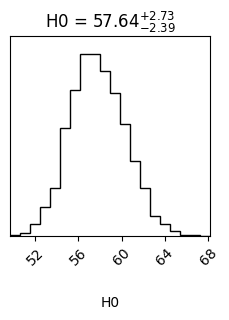

In [23]:
samples_equal_noDE = dyfunc.resample_equal(samples_noDE, weights_noDE)  # Resample weighted samples.
fig = corner.corner(samples_equal_noDE, labels=["H0"], levels=[0.68,0.95], show_titles=True, truth=[71])

In [25]:
# Compute Bayes factor (evidence ratio between models)
Z_with_DE = np.exp(sampler.results.logz[-1])
Z_no_DE   = np.exp(sampler_noDE.results.logz[-1])

bayes_factor = Z_with_DE / Z_no_DE
print(f"Bayes factor (with DE / no DE) = {bayes_factor:.2f}")

Bayes factor (with DE / no DE) = 1.76


The Bayes factor between the model with dark energy and the model without dark energy is approximately 1.

According to the Jeffreys scale, a Bayes factor close to 1 indicates that the data do not provide strong evidence in favor of either model. In other words, the result is inconclusive.